# Finding Label Errors in Object Detection (object detection) Datasets

This 5-minute quickstart tutorial demonstrates how to find potential label errors in object detection datasets. In these datasets each example contains a bounding box and a class label surrounding a physical object within an image scene. Using this labeled data, we train a model to predict classes of objects in an image and their physical locations. The example notebook used to train the model is avalible here (link).

Example applications of object detection in computer vision include;
- Medecine, such as identifying foreign objects in x-rays
- Autonomous driving, identifying pedestrians or objects of interest on the road
- Agriculture, picking up crops ready for harvest

This tutorial uses a subset of the [COCO (Common Objects in Context)](https://cocodataset.org/#home) dataset with 5 classes: car, chair, cup, person, traffic light. The images in the dataset are taken from everyday scenes, and the given annotations come from both official COCO and SAMA.

#### Overview of what we we'll do in this tutorial
- Score examples based on their overall label quality score using `cleanlab.object_detection.rank.get_label_quality_scores`
- Find examples with label issues using `cleanlab.object_detection.filter.find_label_issues`
- Visualize examples using `cleanlab.object_detection.rank.visualize`

<div class="alert alert-info">
Quickstart
<br/>
    
Already have `labels` and `predictions` in the proper format? Just run the code below to find label issues in your object detection dataset.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.object_detection.rank import find_label_issues
from cleanlab.object_detection.filter import get_label_quality_scores

# To get boolean vector of label issues for all images
is_label_issue = find_label_issues(labels, predictions)

# To get label quality scores for all images
label_quality_scores = get_label_quality_scores(labels, predictions)
    
    
```

</div>
</div>

# 1. Install required dependencies and download data
You can use `pip` to install all packages required for this tutorial as follows
```
!pip install cleanlab
!pip insrall matplotlib
```

In [2]:
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ObjectDetectionBenchmarking/sample_coco/labels_coco_X101.pkl'
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ObjectDetectionBenchmarking/sample_coco/results_coco_X101.pkl'
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ObjectDetectionBenchmarking/sample_coco/sample_coco.zip' && unzip -q -o sample_coco.zip

--2023-05-02 20:49:07--  https://cleanlab-public.s3.amazonaws.com/ObjectDetectionBenchmarking/sample_coco/labels_coco_X101.pkl
Resolving cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)... 52.216.170.187, 52.216.207.235, 52.217.198.121, ...
Connecting to cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)|52.216.170.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 698249 (682K) [binary/octet-stream]
Saving to: 'labels_coco_X101.pkl'

labels_coco_X101.pk 100%[===================>] 681.88K   797KB/s    in 0.9s    

2023-05-02 20:49:09 (797 KB/s) - 'labels_coco_X101.pkl' saved [698249/698249]

--2023-05-02 20:49:09--  https://cleanlab-public.s3.amazonaws.com/ObjectDetectionBenchmarking/sample_coco/results_coco_X101.pkl
Resolving cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)... 3.5.9.100, 52.216.207.235, 52.217.198.121, ...
Connecting to cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)|

In [1]:
import pickle

from cleanlab.object_detection.rank import get_label_quality_scores, issues_from_scores, visualize
from cleanlab.object_detection.filter import find_label_issues

# 2. Format data, labels and model predictions

In object detection datasets, each given `label` is a made up of bounding box coordinates and a class label. A model `prediction` is also made up of a bounding box and class label as well as the model confidence in the prediction (i.e. probability the prediction is correct). For both `get_label_quality_scores` and `find_label_issues` cleanlab requires a list of given labels and a list of model predictions for all examples.

The expected format of these `labels` and `predictions` is modeled after what common models like mmdet (link) and detectron2 (link) expect. 

`labels` is a list of dictionaries where `labels[i]` is a dictionary containing key `labels`, which is a list of class labels corresponding key `bboxxes`, which is a numpy array of bounding boxes. Each bounding box in `labels[i]['bboxes']` is in the format is in the format ``[x1,y1,x2,y2]`` where `(x1,y1)` corresponds to the left hand corner of the box and `(x2,y2)` corresponds to the right. An example output of `labels[i]` is below:

```
{'bboxes': array([[ 26.5 , 215.25,  88.  , 229.75],
        [116.5 , 189.57, 166.5 , 215.07],
        [241.95, 180.42, 293.32, 225.82]], dtype=float32),
 'labels': array([1, 1, 1]), 
 ...
 'seg_map': '000000037777.png'} 
```

`predictions` is a list of numpy arrays where `predictions[i]` is of shape `(M,)` where `M` is the number of classes and `predictions[i][m]` is of shape `(L,5)` where `L` is the number of bounding boxes for class `k` and the five columns correspond to ``[x1,y1,x2,y2,pred_prob]`` returned by the model. Here `pred_prob` is the model confidence in the predicted label. Our example uses `K == 5` classes which is why `predictions[0].shape = (5,)`.

An example output of `predictions[i]` is below:

```
array([array([], shape=(0, 5), dtype=float32),
       array([[2.41300339e+02, 1.77116043e+02, 2.97747314e+02, 2.28405350e+02,
               1.15757108e-01],
              [8.42839813e+01, 1.88506973e+02, 1.69366867e+02, 2.28179962e+02,
               1.06976844e-01]], dtype=float32)                               ,
       array([[2.09936218e+02, 1.22989265e+02, 2.15952652e+02, 1.33577789e+02,
               2.66048908e-01],
              [3.35775848e+02, 5.53170547e+01, 3.52000000e+02, 7.79105530e+01,
               6.99099600e-02]], dtype=float32)                               ,
       array([], shape=(0, 5), dtype=float32),
       array([], shape=(0, 5), dtype=float32)], dtype=object)
```

Once you have pred_probs and labels in the appropriate formats, you can find label issues with cleanlab for any object detection dataset!

In [2]:
predictions = pickle.load(open("detectron_coco_5labels_inference_more_epochs.pkl", "rb"))
labels = pickle.load(open("cocoval_dataset_X101_5labels.pkl", "rb"))

In [3]:
pwd

'/Users/adityathyagarajan/code/examples/object_detection'

Here’s what these look like for an example in our synthetic object detection dataset.

In [4]:
example_idx = 16
predictions[example_idx]

[array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32)]

In [7]:
pwd

'/Users/adityathyagarajan/code/examples/object_detection'

We can visualize the bounding boxes and labels side by side using `cleanlabs.object_detection.rank.visualize` function. Here the given labels are in red and the predicted in blue.

In [6]:
image_path = '/home//' + labels[example_idx]['seg_map']

visualize(image_path, labels[example_idx], predictions[example_idx])

FileNotFoundError: [Errno 2] No such file or directory: 'example_images/000000289393.png'

# 3. Use cleanlab to find label issues
Based on the given `labels` and model `predictions` from our trained model, cleanlab can quickly help us find examples that contain label errors in the dataset. In object detection, label errors are annotations that are more likely imperfect.

Examples are imperfect when annotators:
- overlooked an object (missing annotated bounding box),
- chose the wrong class label for an annotated box in the correct location,
- imperfectly annotated the location/edges of a bounding box.


For cleanlab, any of these annotation errors should lead to an image with a lower label quality score.

In [18]:
import numpy as np

In [28]:
# predictions = np.array(predictions)

In [20]:
label_issues = find_label_issues(labels, predictions)[:15]
label_issues

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

## Label quality scores
The above example shows how to identify which examples have label quality issues. We can also compute scores for each example in the dataset which estimate our confidence that this example has been correctly labeled. These scores range between 0 and 1 with smaller values indicating examples whose annotation seems more likely to be imprefect.

In [21]:
scores = get_label_quality_scores(labels, predictions)[:10]
scores

array([0.20010207, 0.21649592, 0.22709222, 0.01499562, 0.1994355 ,
       0.2132762 , 0.23570977, 0.23897679, 0.22519157, 0.21221196])

We can also use **issues_from_scores()** which returns an array of issue indices sorted from most to least severe who's label quality scores fall below the threshold if one is provided.

In [22]:
issue_idx = issues_from_scores(scores, threshold=0.5)[:10]
issue_idx, scores[issue_idx]

(array([3, 4, 0, 9, 5, 1, 8, 2, 6, 7]),
 array([0.01499562, 0.1994355 , 0.20010207, 0.21221196, 0.2132762 ,
        0.21649592, 0.22519157, 0.22709222, 0.23570977, 0.23897679]))

# 4. Visualize Label Issues
Finally, we can use cleanlab functionality to visualize the potential issue errors. Lets only view the images cleanlab identified as issues in our test dataset. To make analysis easier we can also input a `class_labels` dictionary into the function to show up as a legend.

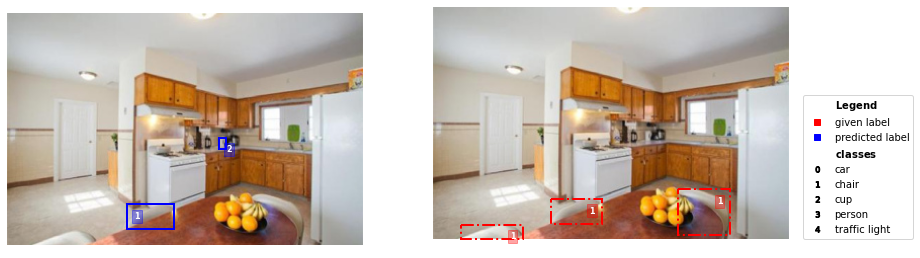

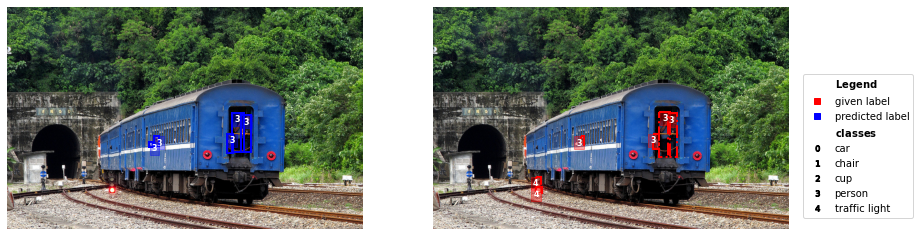

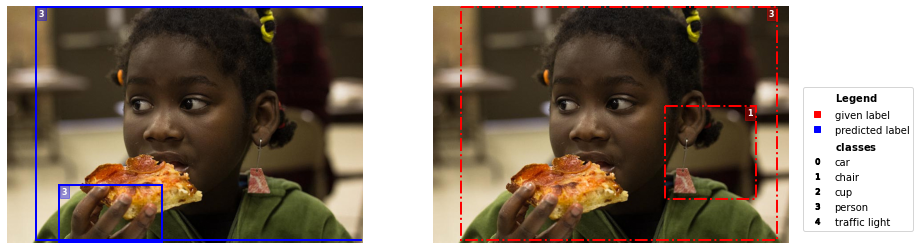

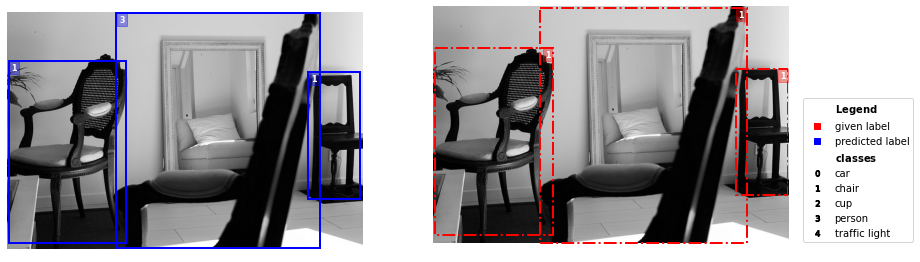

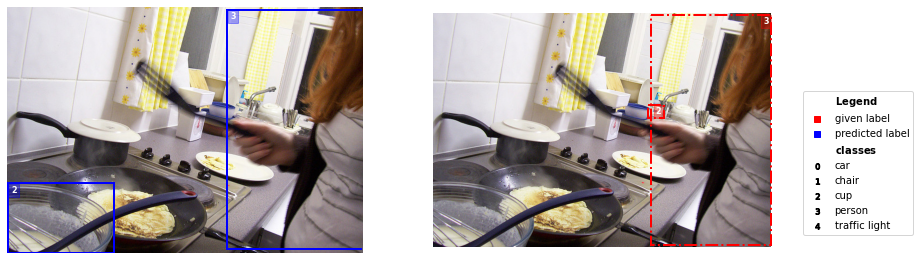

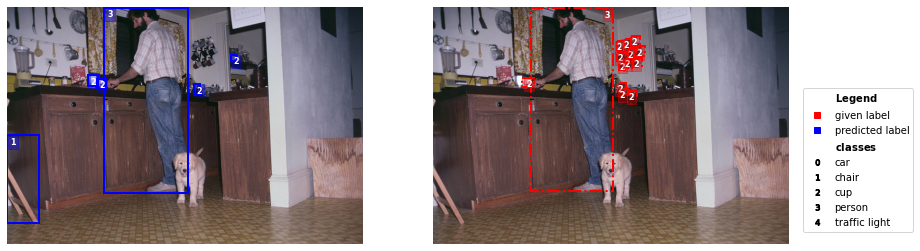

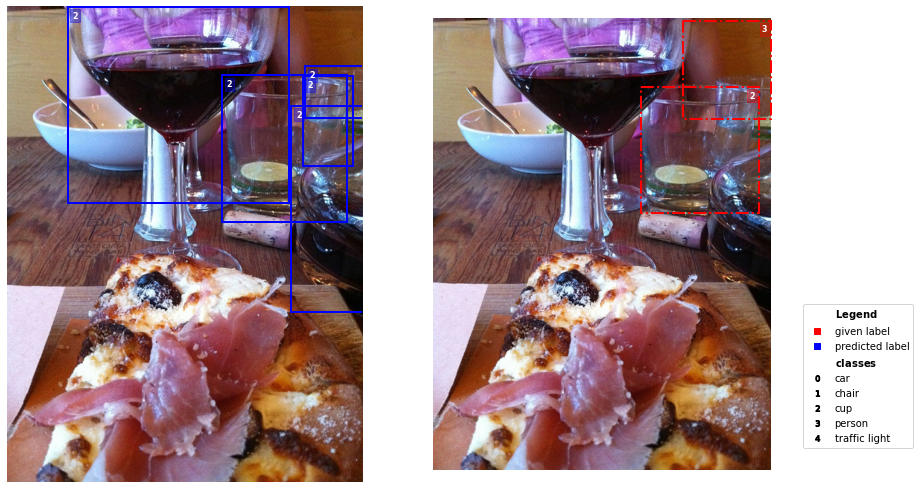

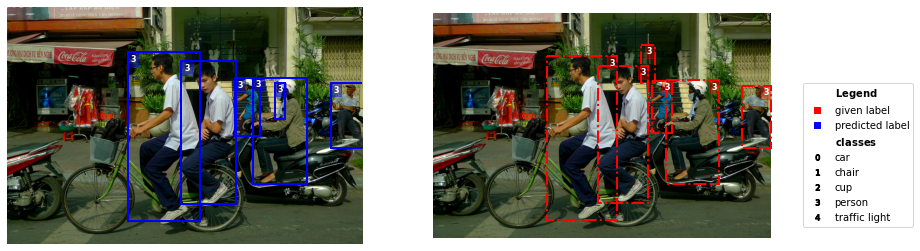

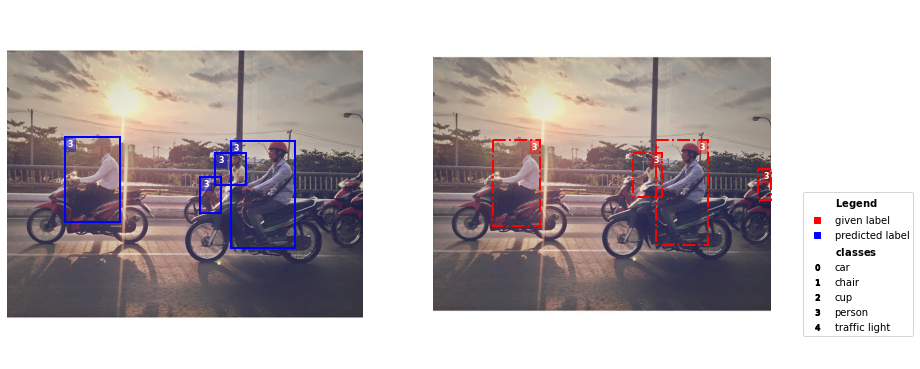

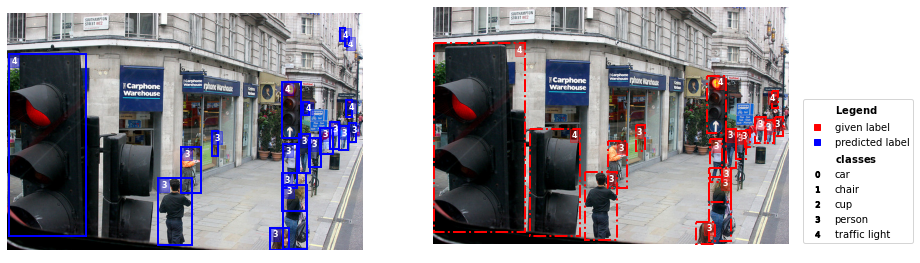

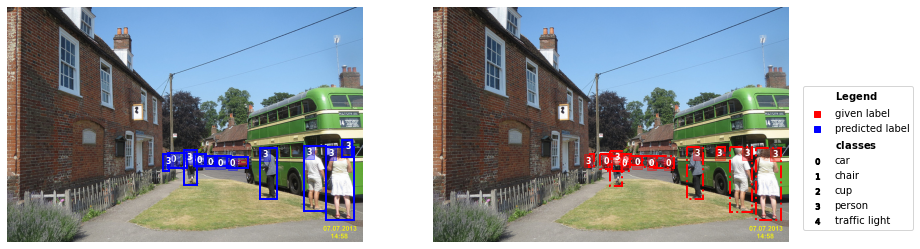

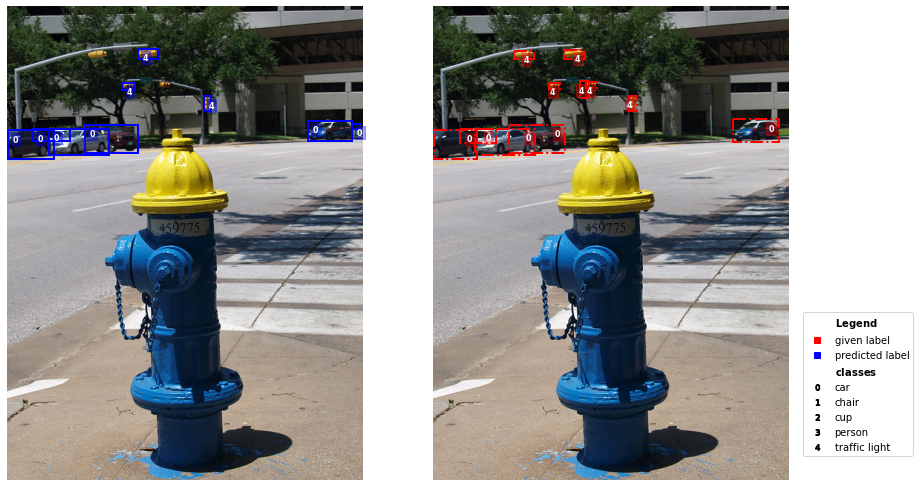

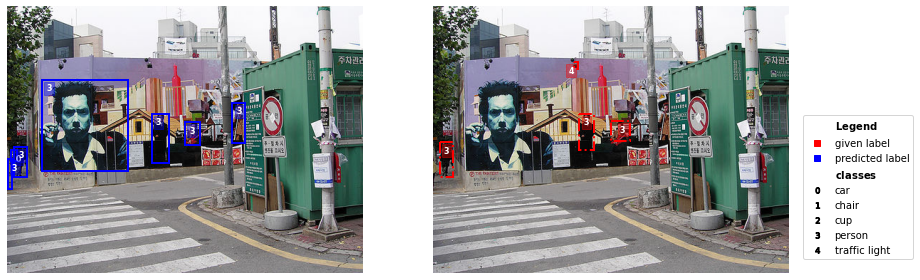

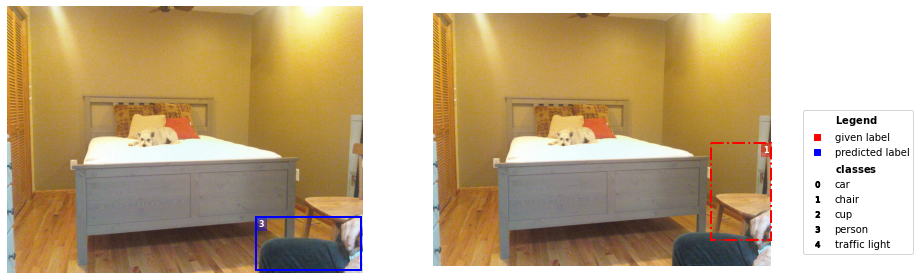

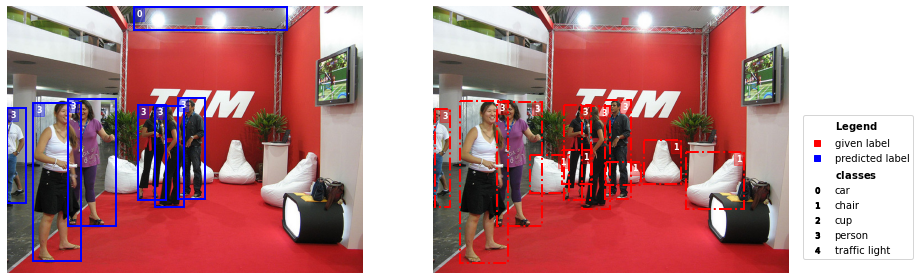

In [23]:
# create a class_labels dictionary to pass in and see labels in the legend
class_labels = {"0": "car", "1": "chair", "2": "cup", "3":"person", "4": "traffic light"}

issue_predictions = [predictions[idx] for idx in range(len(label_issues)) if label_issues[idx]]
issue_labels = [labels[idx] for idx in range(len(label_issues)) if label_issues[idx]]

for prediction,label in zip(issue_predictions,issue_labels):
    image_path = 'example_images/' + label['seg_map']
    visualize(image_path, label, prediction, class_labels=class_labels, given_label_overlay=False)

# [comentary on the data after the correct dataset is used]

In [ ]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

assert 3 in issue_idx